In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:

# Load the datasets
matches = pd.read_csv("matches.csv")
deliveries = pd.read_csv("deliveries.csv")

# Merge datasets on match_id (deliveries) and id (matches)
merged_df = deliveries.merge(
    matches[['id', 'winner', 'target_runs', 'target_overs', 'toss_decision', 'city']],
    left_on='match_id',
    right_on='id',
    how='left'
)

# Preview the merged dataset
print(merged_df.shape)
print(merged_df[['match_id', 'batting_team', 'bowling_team', 'over', 'ball', 'total_runs', 'winner']].head())


(260920, 23)
   match_id           batting_team                 bowling_team  over  ball  \
0    335982  Kolkata Knight Riders  Royal Challengers Bangalore     0     1   
1    335982  Kolkata Knight Riders  Royal Challengers Bangalore     0     2   
2    335982  Kolkata Knight Riders  Royal Challengers Bangalore     0     3   
3    335982  Kolkata Knight Riders  Royal Challengers Bangalore     0     4   
4    335982  Kolkata Knight Riders  Royal Challengers Bangalore     0     5   

   total_runs                 winner  
0           1  Kolkata Knight Riders  
1           0  Kolkata Knight Riders  
2           1  Kolkata Knight Riders  
3           0  Kolkata Knight Riders  
4           0  Kolkata Knight Riders  


In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   match_id          260920 non-null  int64  
 1   inning            260920 non-null  int64  
 2   batting_team      260920 non-null  object 
 3   bowling_team      260920 non-null  object 
 4   over              260920 non-null  int64  
 5   ball              260920 non-null  int64  
 6   batter            260920 non-null  object 
 7   bowler            260920 non-null  object 
 8   non_striker       260920 non-null  object 
 9   batsman_runs      260920 non-null  int64  
 10  extra_runs        260920 non-null  int64  
 11  total_runs        260920 non-null  int64  
 12  extras_type       14125 non-null   object 
 13  is_wicket         260920 non-null  int64  
 14  player_dismissed  12950 non-null   object 
 15  dismissal_kind    12950 non-null   object 
 16  fielder           93

In [5]:
# Define target column: did the batting team win this match?
merged_df['will_batting_team_win'] = (merged_df['batting_team'] == merged_df['winner']).astype(int)

# Check result
print(merged_df[['match_id', 'batting_team', 'winner', 'will_batting_team_win']].head())
print(merged_df['will_batting_team_win'].value_counts())


   match_id           batting_team                 winner  \
0    335982  Kolkata Knight Riders  Kolkata Knight Riders   
1    335982  Kolkata Knight Riders  Kolkata Knight Riders   
2    335982  Kolkata Knight Riders  Kolkata Knight Riders   
3    335982  Kolkata Knight Riders  Kolkata Knight Riders   
4    335982  Kolkata Knight Riders  Kolkata Knight Riders   

   will_batting_team_win  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
will_batting_team_win
0    133435
1    127485
Name: count, dtype: int64


In [6]:
# Filter only second innings
second_innings_df = merged_df[merged_df['inning'] == 2].copy()


In [7]:
second_innings_df.shape

(125741, 24)

In [8]:
# Cumulative runs and wickets
second_innings_df['current_score'] = second_innings_df.groupby('match_id')['total_runs'].cumsum()
second_innings_df['wickets_fallen'] = second_innings_df.groupby('match_id')['is_wicket'].cumsum()

# Balls bowled so far
second_innings_df['balls_bowled'] = ((second_innings_df['over'] - 1) * 6 + second_innings_df['ball'])

# Balls remaining in chase
second_innings_df['balls_remaining'] = (second_innings_df['target_overs'] * 6) - second_innings_df['balls_bowled']

# Runs required
second_innings_df['required_runs'] = second_innings_df['target_runs'] - second_innings_df['current_score']

# Run rates
second_innings_df['current_run_rate'] = second_innings_df['current_score'] / second_innings_df['balls_bowled'].replace(0, 1)
second_innings_df['required_run_rate'] = second_innings_df['required_runs'] / second_innings_df['balls_remaining'].replace(0, 1)


In [9]:
second_innings_df = second_innings_df[
    (second_innings_df['balls_remaining'] > 0) & 
    (second_innings_df['required_runs'] > 0)
]


In [10]:
second_innings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125097 entries, 124 to 260918
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   match_id               125097 non-null  int64  
 1   inning                 125097 non-null  int64  
 2   batting_team           125097 non-null  object 
 3   bowling_team           125097 non-null  object 
 4   over                   125097 non-null  int64  
 5   ball                   125097 non-null  int64  
 6   batter                 125097 non-null  object 
 7   bowler                 125097 non-null  object 
 8   non_striker            125097 non-null  object 
 9   batsman_runs           125097 non-null  int64  
 10  extra_runs             125097 non-null  int64  
 11  total_runs             125097 non-null  int64  
 12  extras_type            6709 non-null    object 
 13  is_wicket              125097 non-null  int64  
 14  player_dismissed       6226 non-null   

In [11]:
from sklearn.preprocessing import LabelEncoder

# Select relevant features + target
features = [
    'current_score', 'wickets_fallen', 'balls_bowled', 'balls_remaining',
    'required_runs', 'current_run_rate', 'required_run_rate',
    'batting_team', 'bowling_team', 'city', 'toss_decision'
]

df_model = second_innings_df[features + ['will_batting_team_win']].copy()

# Encode categorical features
categorical_cols = ['batting_team', 'bowling_team', 'city', 'toss_decision']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le  # Save encoder if you want to use it later in prediction


In [12]:
from sklearn.model_selection import train_test_split

X = df_model.drop('will_batting_team_win', axis=1)
y = df_model['will_batting_team_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


In [14]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy * 100, 2), "%")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 84.16 %
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83     12079
           1       0.84      0.86      0.85     12941

    accuracy                           0.84     25020
   macro avg       0.84      0.84      0.84     25020
weighted avg       0.84      0.84      0.84     25020

Confusion Matrix:
 [[ 9899  2180]
 [ 1783 11158]]


In [ ]:
print(y.value_counts(normalize=True))  


will_batting_team_win
1    0.517215
0    0.482785
Name: proportion, dtype: float64


In [19]:
# Filter only up to 100 balls bowled (approx. 16.4 overs)
df_model_filtered = df_model[df_model['balls_bowled'] <= 100].copy()

# Check new shape
print("Filtered rows:", df_model_filtered.shape)


Filtered rows: (115244, 12)


In [20]:
from sklearn.model_selection import train_test_split

X_filtered = df_model_filtered.drop('will_batting_team_win', axis=1)
y_filtered = df_model_filtered['will_batting_team_win']

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)


In [21]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)


c:\Users\tvisha.k\Documents\Tvisha\Projects\ipl-eda\ipl_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:34:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy (early overs only):", round(accuracy * 100, 2), "%")

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


XGBoost Accuracy (early overs only): 93.68 %
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93     10813
           1       0.93      0.95      0.94     12236

    accuracy                           0.94     23049
   macro avg       0.94      0.94      0.94     23049
weighted avg       0.94      0.94      0.94     23049

Confusion Matrix:
 [[ 9990   823]
 [  634 11602]]


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

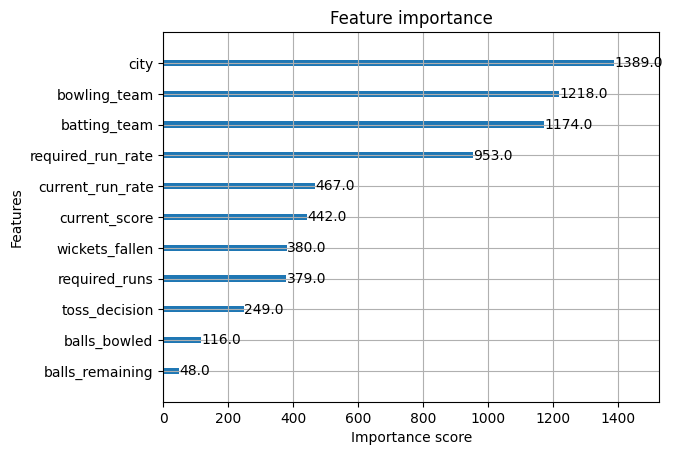

In [24]:
xgb.plot_importance(xgb_model)


Hyperparameter Tuning


In [25]:
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42
    }

    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)


c:\Users\tvisha.k\Documents\Tvisha\Projects\ipl-eda\ipl_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best Parameters:", study.best_params)
print("Best Accuracy:", round(study.best_value * 100, 2), "%")


[I 2025-06-26 17:36:32,779] A new study created in memory with name: no-name-ee260daf-637c-4b63-993d-c837e9934694
c:\Users\tvisha.k\Documents\Tvisha\Projects\ipl-eda\ipl_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:36:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-26 17:36:33,889] Trial 0 finished with value: 0.8463707753047854 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.12422076569542836, 'subsample': 0.5930371986052017, 'colsample_bytree': 0.9955344125525807, 'gamma': 1.3363617926994198}. Best is trial 0 with value: 0.8463707753047854.
c:\Users\tvisha.k\Documents\Tvisha\Projects\ipl-eda\ipl_env\lib\site-packages\xgboost\training.py:183: UserWarning: [17:36:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterat

Best Parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.1675598313108744, 'subsample': 0.5831949967179169, 'colsample_bytree': 0.8007401351258919, 'gamma': 0.22837381744446095}
Best Accuracy: 99.7 %


Best Model Accuracy: 99.68 %


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

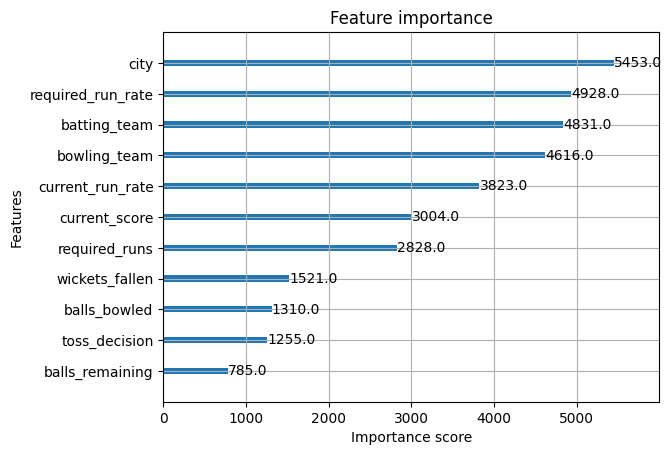

In [28]:
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Best Model Accuracy:", round(accuracy_best * 100, 2), "%")
# Feature importance for the best model
xgb.plot_importance(best_model)

